In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
df = pd.read_csv('mtsamples.csv')
df = df.drop(columns='Unnamed: 0')
df

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


# Анализ данных

In [39]:
train_df, test_df = train_test_split(df, random_state=42, stratify=df['keywords'].isnull())

print("Размер тренировочного набора:", train_df.shape)
print("Размер тестового набора:", test_df.shape)

Размер тренировочного набора: (3749, 5)
Размер тестового набора: (1250, 5)


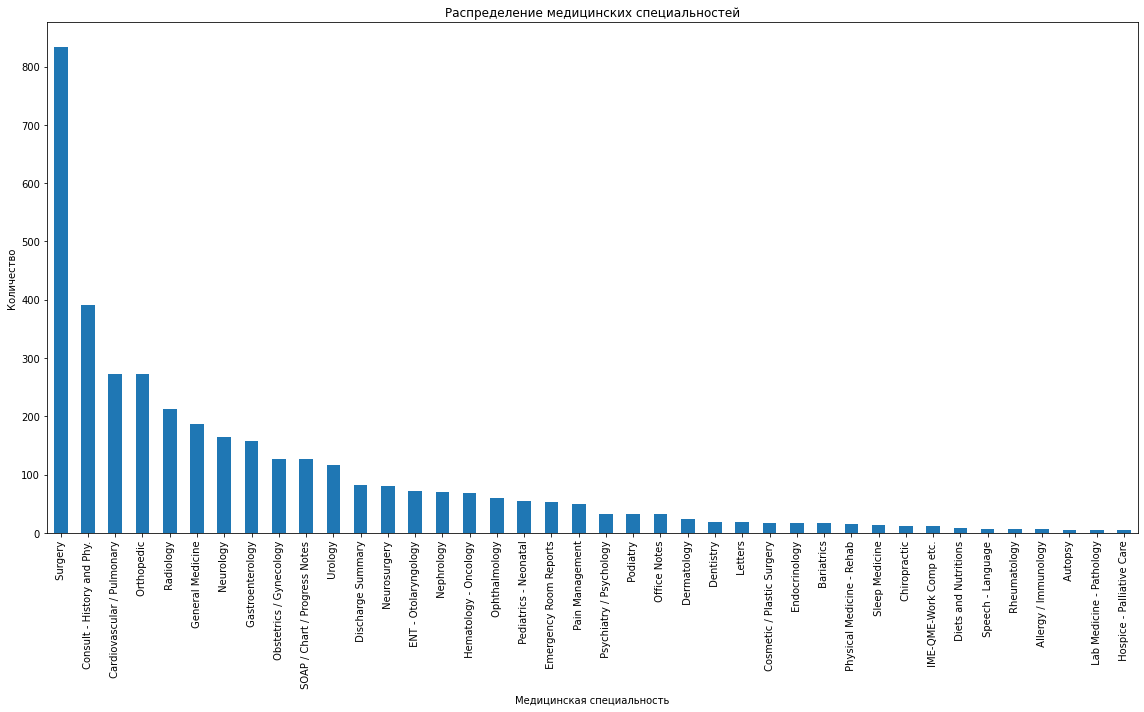

In [38]:
specialty_counts = train_df['medical_specialty'].value_counts()

plt.figure(figsize=(16,10))
specialty_counts.plot(kind='bar')
plt.title('Распределение медицинских специальностей')
plt.xlabel('Медицинская специальность')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
len(train_df['medical_specialty'].value_counts())

40

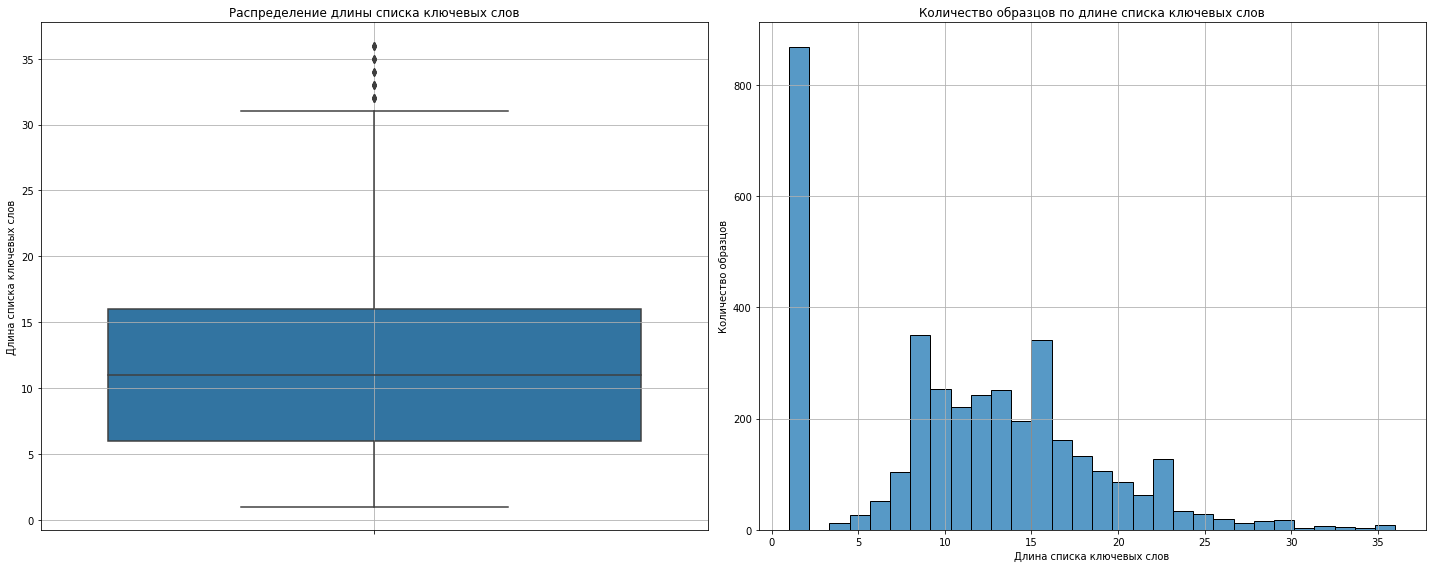

In [48]:
keyword_lengths = train_df['keywords'].apply(lambda x: len(str(x).split(',')))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=keyword_lengths, data=train_df)
plt.title('Распределение длины списка ключевых слов')
plt.ylabel('Длина списка ключевых слов')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=keyword_lengths, bins=30)
plt.title('Количество образцов по длине списка ключевых слов')
plt.xlabel('Длина списка ключевых слов')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

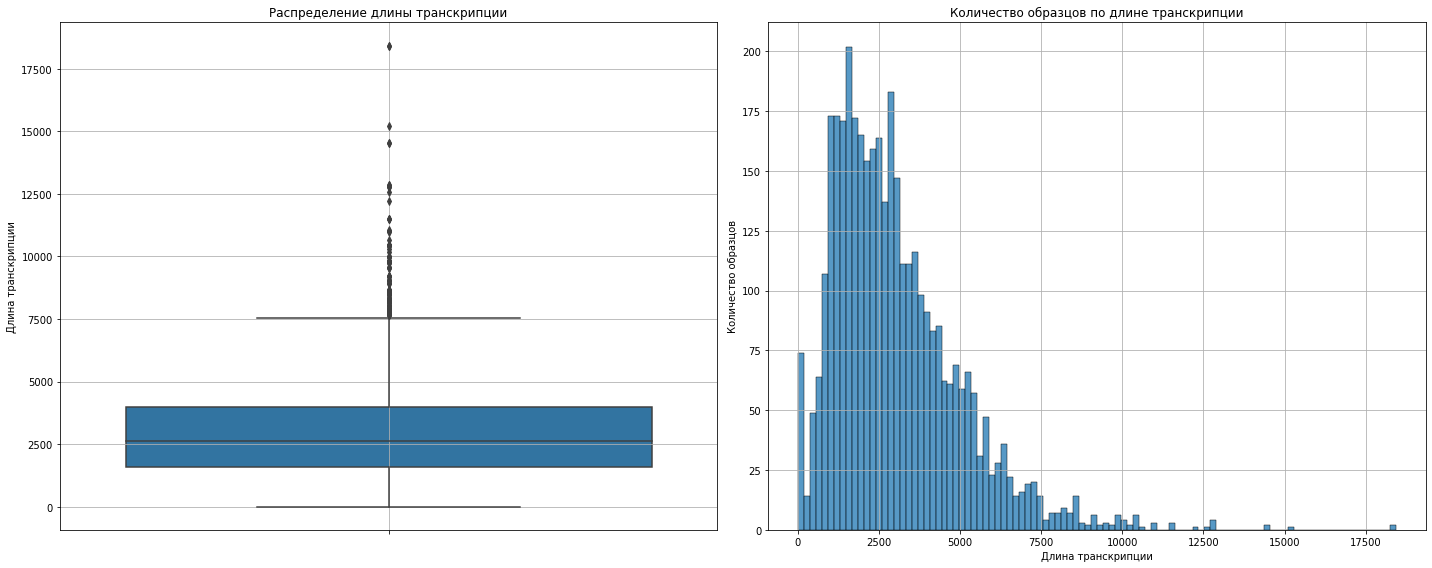

In [53]:
transcription_lengths = train_df['transcription'].apply(lambda x: len(str(x)))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=transcription_lengths, data=train_df)
plt.title('Распределение длины транскрипции')
plt.ylabel('Длина транскрипции')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=transcription_lengths, bins=100)
plt.title('Количество образцов по длине транскрипции')
plt.xlabel('Длина транскрипции')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

# BERT

## Предобработка данных

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaModel, RobertaTokenizer
from transformers import BertTokenizer
from keras.utils import pad_sequences

2024-04-21 19:09:10.079676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df = df.dropna(subset=['transcription'])
X = df['transcription'].tolist()
X = [str(text) for text in X if pd.notnull(text)]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['medical_specialty'])
y = encoded_labels

In [5]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained("without_anomalies_PUBMEDBERT_tokenizer")

inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, inputs['input_ids'].size(0), batch_size)):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = generate_embeddings(model, inputs)

100%|██████████| 311/311 [00:49<00:00,  6.31it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
hidden_dim = 256
num_classes = np.unique(y).shape[0]
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

## Обучение модели

In [10]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

epochs = 30
loss_values_train, loss_values_val, f1_values = [], [], []

for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()

        outputs = mlp_model(b_input_ids)

        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        loss.backward()

        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    loss_values_train.append(avg_train_loss)


    mlp_model.eval()
    eval_loss = 0
    predictions, true_labels = [], []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for batch in tqdm(val_loader, desc="Validation", total=len(val_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        
        with torch.no_grad():
            outputs = mlp_model(b_input_ids)
        
        loss = criterion(outputs, b_labels)
        eval_loss += loss.item()

        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)

    eval_loss = eval_loss / len(val_loader)
    loss_values_val.append(eval_loss)
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_values.append(f1)

    print(f'Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Val Loss: {eval_loss} | Val F1: {f1}')
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        best_model_state = mlp_model.state_dict()

Validation: 100%|██████████| 544/544 [00:00<00:00, 1191.72it/s]


Epoch 1 | Train Loss: 2.7832718596738926 | Val Loss: 2.1257983476800075 | Val F1: 0.355229467599161


Validation: 100%|██████████| 544/544 [00:00<00:00, 1157.50it/s]


Epoch 2 | Train Loss: 1.8560420116227048 | Val Loss: 1.6431524777675377 | Val F1: 0.49719295351450876


Validation: 100%|██████████| 544/544 [00:00<00:00, 1184.70it/s]


Epoch 3 | Train Loss: 1.475520453580162 | Val Loss: 1.3868895931826795 | Val F1: 0.5755600182370382


Validation: 100%|██████████| 544/544 [00:00<00:00, 1163.78it/s]


Epoch 4 | Train Loss: 1.266720598015715 | Val Loss: 1.210436667151311 | Val F1: 0.6120420685680295


Validation: 100%|██████████| 544/544 [00:00<00:00, 1164.57it/s]


Epoch 5 | Train Loss: 1.1279622236284994 | Val Loss: 1.105989762910587 | Val F1: 0.6374258381736108


Validation: 100%|██████████| 544/544 [00:00<00:00, 1169.72it/s]


Epoch 6 | Train Loss: 1.0270022773914331 | Val Loss: 1.0251889259225744 | Val F1: 0.6653473921317177


Validation: 100%|██████████| 544/544 [00:00<00:00, 1193.36it/s]


Epoch 7 | Train Loss: 0.9537691926382774 | Val Loss: 0.9993609157116974 | Val F1: 0.6760161436077804


Validation: 100%|██████████| 544/544 [00:00<00:00, 1154.15it/s]


Epoch 8 | Train Loss: 0.8957204293076169 | Val Loss: 0.9350517788244521 | Val F1: 0.6895874629183198


Validation: 100%|██████████| 544/544 [00:00<00:00, 1104.80it/s]


Epoch 9 | Train Loss: 0.8531876899594185 | Val Loss: 0.9014132669031182 | Val F1: 0.7015234426671837


Validation: 100%|██████████| 544/544 [00:00<00:00, 1194.14it/s]


Epoch 10 | Train Loss: 0.8196203832277188 | Val Loss: 0.8746450062676826 | Val F1: 0.7092501199639193


Validation: 100%|██████████| 544/544 [00:00<00:00, 1185.70it/s]


Epoch 11 | Train Loss: 0.7921561458485895 | Val Loss: 0.8484559851862928 | Val F1: 0.7200334880794493


Validation: 100%|██████████| 544/544 [00:00<00:00, 1194.62it/s]


Epoch 12 | Train Loss: 0.761606102854963 | Val Loss: 0.8281412959537086 | Val F1: 0.7256671032965156


Validation: 100%|██████████| 544/544 [00:00<00:00, 1157.07it/s]


Epoch 13 | Train Loss: 0.7417532991681832 | Val Loss: 0.8329501135329551 | Val F1: 0.7267706829787395


Validation: 100%|██████████| 544/544 [00:00<00:00, 1169.08it/s]


Epoch 14 | Train Loss: 0.7211019289862438 | Val Loss: 0.8385729722623878 | Val F1: 0.7256726957191061


Validation: 100%|██████████| 544/544 [00:00<00:00, 1175.05it/s]


Epoch 15 | Train Loss: 0.7039743220826209 | Val Loss: 0.8222588413833257 | Val F1: 0.7286217303777388


Validation: 100%|██████████| 544/544 [00:00<00:00, 1183.67it/s]


Epoch 16 | Train Loss: 0.6920427087986586 | Val Loss: 0.820263000917347 | Val F1: 0.7258390122607572


Validation: 100%|██████████| 544/544 [00:00<00:00, 1157.50it/s]


Epoch 17 | Train Loss: 0.6799078618710422 | Val Loss: 0.8255905744838802 | Val F1: 0.7218774860884167


Validation: 100%|██████████| 544/544 [00:00<00:00, 1179.40it/s]


Epoch 18 | Train Loss: 0.6688304793605507 | Val Loss: 0.8342494731768966 | Val F1: 0.7128772809970182


Validation: 100%|██████████| 544/544 [00:00<00:00, 1186.62it/s]


Epoch 19 | Train Loss: 0.6628404394906088 | Val Loss: 0.8470374072134933 | Val F1: 0.7151164729378754


Validation: 100%|██████████| 544/544 [00:00<00:00, 1183.10it/s]


Epoch 20 | Train Loss: 0.6544488373271865 | Val Loss: 0.8376015589901191 | Val F1: 0.7260542818297726


Validation: 100%|██████████| 544/544 [00:00<00:00, 1184.57it/s]


Epoch 21 | Train Loss: 0.6407642651728227 | Val Loss: 0.8539667895118541 | Val F1: 0.7204485983897916


Validation: 100%|██████████| 544/544 [00:00<00:00, 1204.73it/s]


Epoch 22 | Train Loss: 0.6379495747798287 | Val Loss: 0.8212677915306652 | Val F1: 0.7268027582263362


Validation: 100%|██████████| 544/544 [00:00<00:00, 1124.44it/s]


Epoch 23 | Train Loss: 0.6286526130211046 | Val Loss: 0.8246504538829493 | Val F1: 0.7242285072011663


Validation: 100%|██████████| 544/544 [00:00<00:00, 1198.40it/s]


Epoch 24 | Train Loss: 0.622822808992008 | Val Loss: 0.8282262020443073 | Val F1: 0.7247844236098362


Validation: 100%|██████████| 544/544 [00:00<00:00, 1194.96it/s]


Epoch 25 | Train Loss: 0.6147759278743145 | Val Loss: 0.8340057519757572 | Val F1: 0.7233517964013523


Validation: 100%|██████████| 544/544 [00:00<00:00, 1164.82it/s]


Epoch 26 | Train Loss: 0.6082001802255856 | Val Loss: 0.8425814683329972 | Val F1: 0.7259598184272744


Validation: 100%|██████████| 544/544 [00:00<00:00, 1185.59it/s]


Epoch 27 | Train Loss: 0.6026531211260304 | Val Loss: 0.8672994329895386 | Val F1: 0.7206303424800967


Validation: 100%|██████████| 544/544 [00:00<00:00, 1116.33it/s]


Epoch 28 | Train Loss: 0.6054300908684073 | Val Loss: 0.8436555440592415 | Val F1: 0.7247310920061638


Validation: 100%|██████████| 544/544 [00:00<00:00, 1176.18it/s]


Epoch 29 | Train Loss: 0.5956253931200242 | Val Loss: 0.8099133051411413 | Val F1: 0.7357916507274878


Validation: 100%|██████████| 544/544 [00:00<00:00, 1160.06it/s]

Epoch 30 | Train Loss: 0.5956550378274793 | Val Loss: 0.8241225924644181 | Val F1: 0.7284132800903598


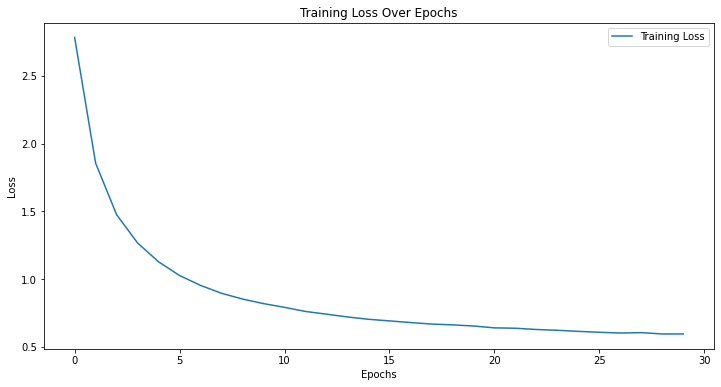

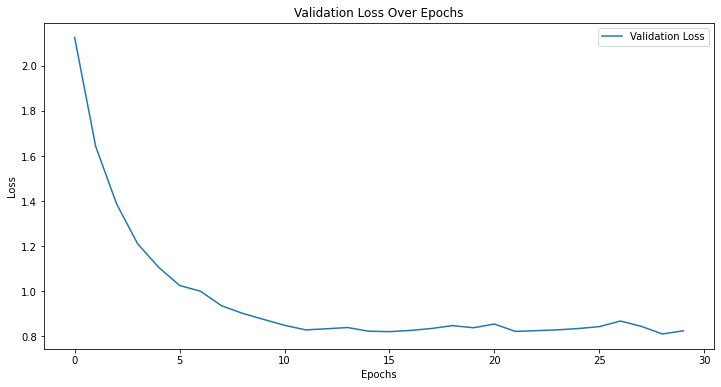

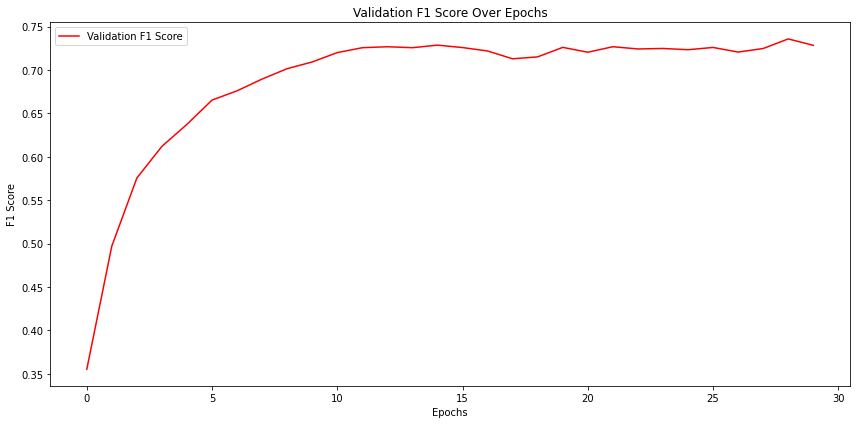

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(loss_values_train, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))

plt.plot(loss_values_val, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(f1_values, label='Validation F1 Score', color='red')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

mlp_model.load_state_dict(best_model_state)
mlp_model.to(device)
mlp_model.eval()

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=8)

test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = mlp_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_pred_labels = encoder.inverse_transform(test_preds)
test_true_labels = encoder.inverse_transform(test_labels)

print("Classification Report on Test Set (Using Loaded Model):")
print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set (Using Loaded Model):
                                precision    recall  f1-score   support

          Allergy / Immunology       0.92      1.00      0.96       227
                       Autopsy       1.00      1.00      1.00       221
                    Bariatrics       0.90      0.91      0.90       230
    Cardiovascular / Pulmonary       0.48      0.38      0.43       204
                  Chiropractic       0.77      0.80      0.79       210
    Consult - History and Phy.       0.35      0.17      0.23       229
    Cosmetic / Plastic Surgery       0.76      0.80      0.78       208
                     Dentistry       0.94      0.89      0.91       229
                   Dermatology       0.88      0.87      0.88       213
          Diets and Nutritions       0.92      1.00      0.96       209
             Discharge Summary       0.55      0.74      0.63       214
          ENT - Otolaryngology       0.75      0.59      0.66       204
       

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)

cm = confusion_matrix(test_true_labels, test_pred_labels)

                                precision    recall  f1-score   support

          Allergy / Immunology       0.92      1.00      0.96       227
                       Autopsy       1.00      1.00      1.00       221
                    Bariatrics       0.90      0.91      0.90       230
    Cardiovascular / Pulmonary       0.48      0.38      0.43       204
                  Chiropractic       0.77      0.80      0.79       210
    Consult - History and Phy.       0.35      0.17      0.23       229
    Cosmetic / Plastic Surgery       0.76      0.80      0.78       208
                     Dentistry       0.94      0.89      0.91       229
                   Dermatology       0.88      0.87      0.88       213
          Diets and Nutritions       0.92      1.00      0.96       209
             Discharge Summary       0.55      0.74      0.63       214
          ENT - Otolaryngology       0.75      0.59      0.66       204
        Emergency Room Reports       0.59      0.80      0.68  

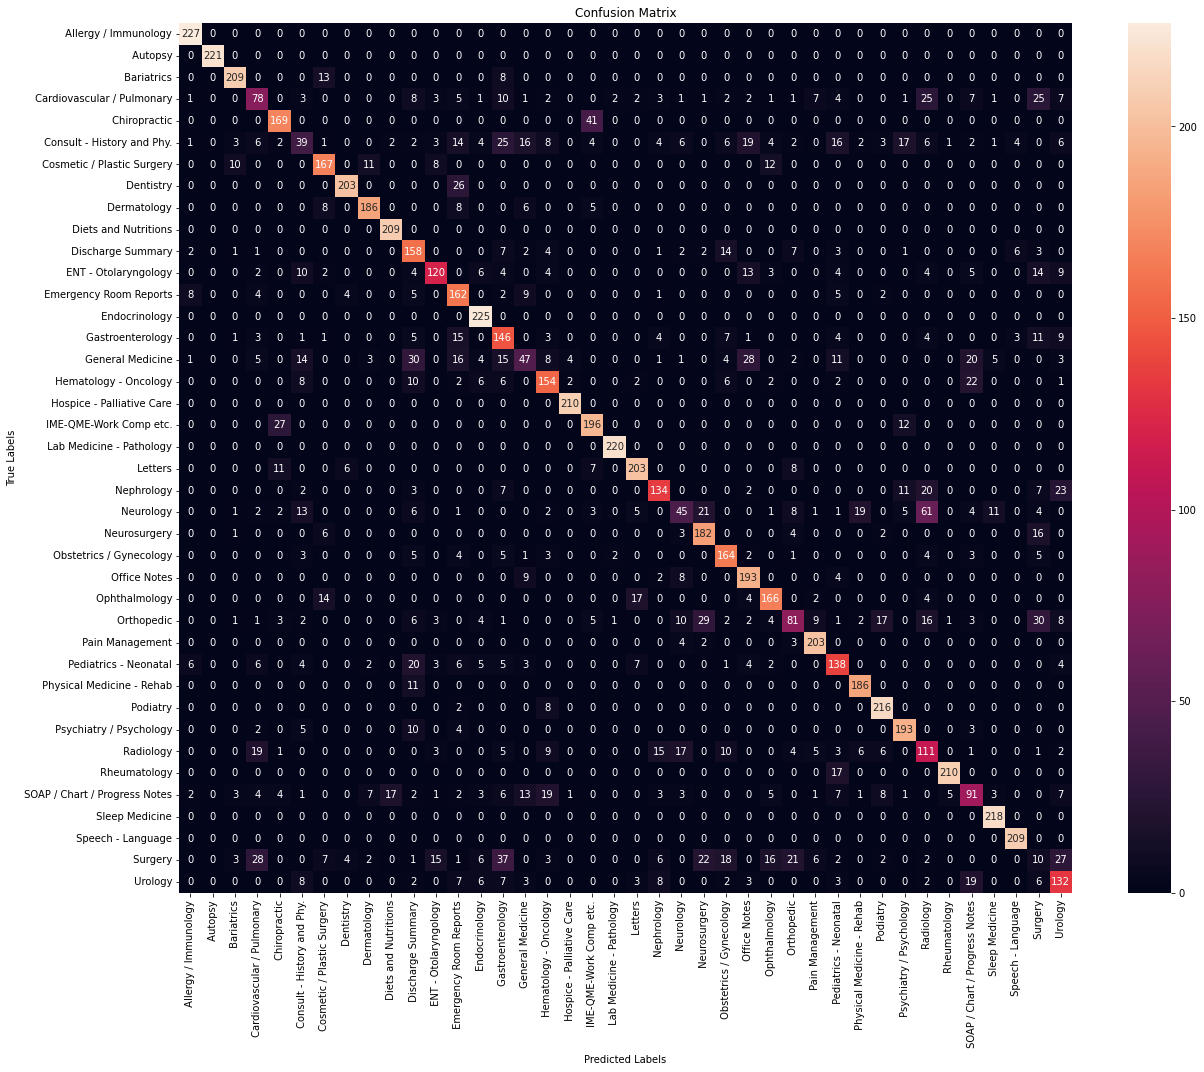

In [14]:
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(test_true_labels), yticklabels=np.unique(test_true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

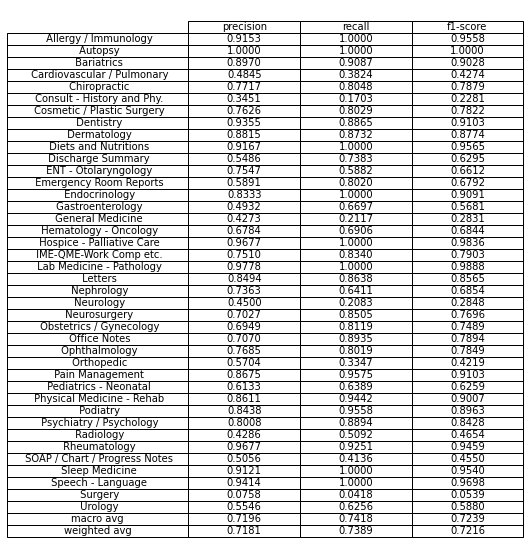

In [15]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('tight')
ax.axis('off')
formatted_cell_text = [
    [f"{value:.4f}" if isinstance(value, float) else f"{value}" for value in list(report[cls].values())[:-1]]
    for cls in report if cls != 'accuracy'
]

the_table = ax.table(
    cellText=formatted_cell_text,
    colLabels=['precision', 'recall', 'f1-score', 'support'],
    rowLabels=[cls for cls in report if cls != 'accuracy'],
    cellLoc='center', 
    rowLoc='center', 
    loc='center'
)

plt.show()
